# This tutorial will show the server workflow in action on real images. For more information, see server_explanatory.ipynb

In [792]:
import os
import sys
import json
import numpy as np
from ptolemy.mrc import load_mrc
import matplotlib.pyplot as plt
import requests
import io
import pandas as pd
import ptolemy.visualization as viz


In [793]:
# Server initialized at localhost:8000 with 
# uvicorn ptolemy.ptolemy_server:app

baseurl = "http://127.0.0.1:8000/"
session_path = 'example_sessions/n22mar18f/'

(-0.5, 1023.5, 1023.5, -0.5)

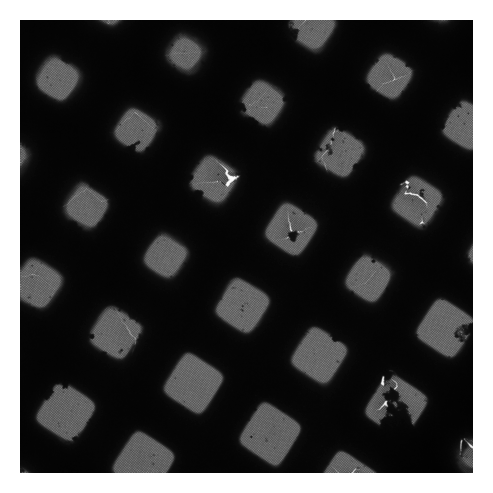

In [794]:
# microscope acquires first tile image
acquired_lm = load_mrc(session_path + 'gr/22083436.mrc')
plt.figure(figsize=(3, 3), dpi=200)
plt.imshow(acquired_lm, cmap='Greys_r')
plt.axis('off')

In [795]:
# make post request to push lm
payload = {
    'image': acquired_lm.tolist(),
    'grid_id': 0,
    'tile_id': 0
}
payload = json.dumps(payload)
requests.post(baseurl + 'push_lm', payload)

<Response [200]>

In [796]:
# Inspecting the state at this point
response = requests.get(baseurl + 'current_lm_state')
lm_state = pd.read_csv(io.StringIO(response.json()), index_col='square_id')
lm_state.head()

tile_id  grid_id  prior_score  visited  center_x  center_y
square_id                                                            
0                0        0     0.002196    False       203         1
1                0        0     0.128330    False       657        19
2                0        0     0.007940    False       950         0
3                0        0     0.164252    False       374        75
4                0        0     0.296050    False       835       126

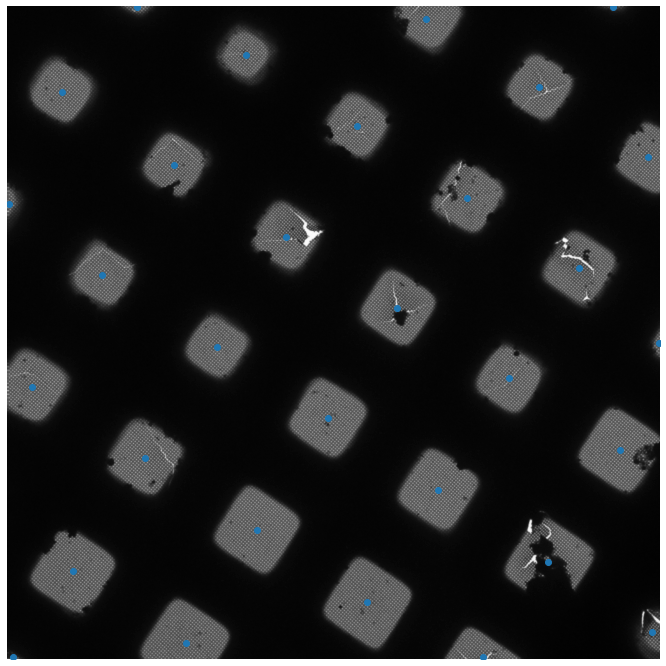

In [797]:
viz.viz_lm_image(acquired_lm, centers=np.stack((lm_state.center_x.values, lm_state.center_y.values), axis=1))

In [798]:
response = requests.post(baseurl + 'select_next_square', data=json.dumps({"value": -1}))


In [799]:
# resetting the state and pushing many "acquired" lm images
requests.get(baseurl + 'initialize_new_session')

grid_lm_paths = [x for x in os.listdir('example_sessions/n22mar18f/gr') if '.mrc' in x]

def push_lm(img, grid_id, tile_id):
    payload = {
    'image': img.tolist(),
    'grid_id': grid_id,
    'tile_id': tile_id
    }
    payload = json.dumps(payload)
    requests.post(baseurl + 'push_lm', payload)

for i, path in enumerate(grid_lm_paths):
    lm_img = load_mrc(session_path +'gr/' + path)
    push_lm(lm_img, 0, i)



In [800]:
# Inspecting the state at this point
response = requests.get(baseurl + 'current_lm_state')
lm_state = pd.read_csv(io.StringIO(response.json()), index_col='square_id')
lm_state.head()

tile_id  grid_id  prior_score  visited  center_x  center_y
square_id                                                            
0                0        0     0.070085    False       163        20
1                0        0     0.166243    False       911        20
2                0        0     0.104958    False       623        76
3                0        0     0.300327    False       338       133
4                0        0     0.057341    False       795       191

In [801]:
# Picking the first square is a fairly complicated decision. See [TODO]. 
# Assume we picked a first square somehow, went to the square and then took our first mm_grid_image
# The first thing that must be done is to set a no-ice pixel-intensity for the medium-mag images. This is used as a normalization factor for the medium-mag pixels. For more info see [TODO]
payload = {
    'value': 11.039918
}
requests.post(baseurl + 'set_noice_hole_intensity', data=json.dumps(payload))

<Response [200]>

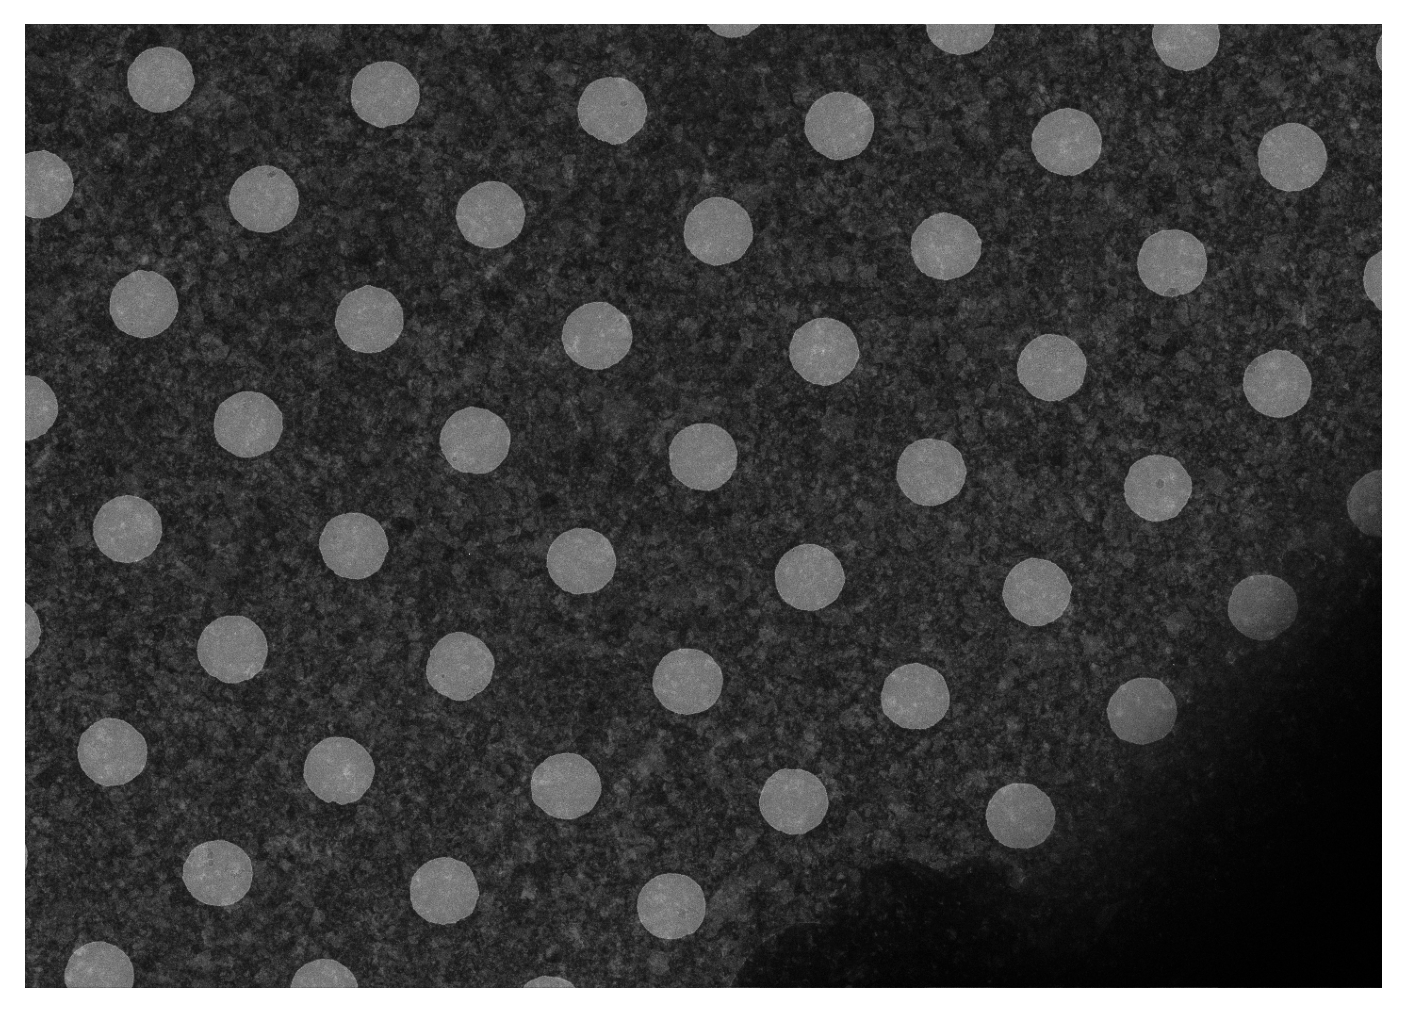

In [802]:
plt.figure(figsize=(7,7), dpi=250)
acquired_mm = load_mrc(session_path + 'hl/22084221.mrc')
# acquired_mm = load_mrc('example_images/med_mag/21feb25a_23139789.mrc')
plt.imshow(acquired_mm, cmap='Greys_r')
plt.axis('off')
plt.show()

In [803]:
payload = {
    'image': acquired_mm.tolist(),
    'grid_id': 0,
    'square_id': 0
}
response = requests.post(baseurl + 'push_and_evaluate_mm', data=json.dumps(payload))
hole_df = pd.read_csv(io.StringIO(response.json()), index_col='hole_id')
hole_df.head()

mm_img_id  square_id  grid_id  radius  prior_score  visited  ctf  \
hole_id                                                                     
0              NaN          0        0      36     0.070223    False  NaN   
1              NaN          0        0      36     0.181347    False  NaN   
2              NaN          0        0      36     0.381504    False  NaN   
3              NaN          0        0      36     0.004270    False  NaN   
4              NaN          0        0      36     0.281875    False  NaN   

         ice_thickness  ctf_pred  ice_pred  ctf_var  ice_var  center_x  \
hole_id                                                                  
0                  NaN       2.0      50.0      1.0     20.0        10   
1                  NaN       2.0      50.0      1.0     20.0       139   
2                  NaN       2.0      50.0      1.0     20.0       122   
3                  NaN       2.0      50.0      1.0     20.0       251   
4                  NaN       2.0      50.0      1.0     20.0       379   

         center_y  
hole_id            
0             166  
1              54  
2             295  
3             183  
4              71

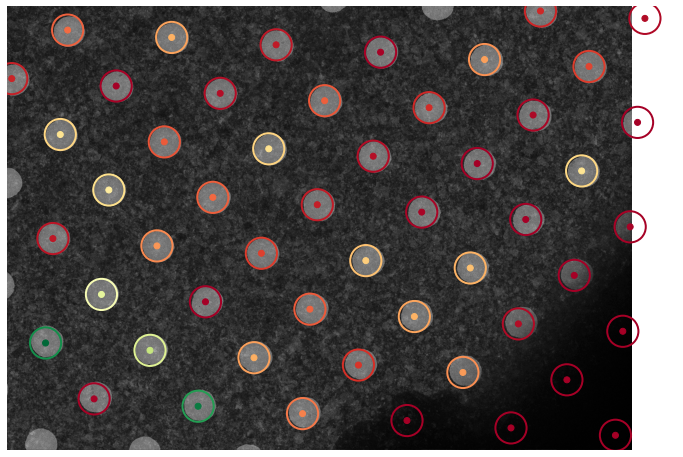

In [804]:
viz.viz_mm_image(acquired_mm, np.stack((hole_df.center_x.values, hole_df.center_y.values), axis=1), list(hole_df.radius), hole_df.prior_score)

In [805]:
# OK, that prior score looks pretty ugly. I think the fix is to crop based on the radius. We'll have to fix this later

In [806]:
hole_df.head()

mm_img_id  square_id  grid_id  radius  prior_score  visited  ctf  \
hole_id                                                                     
0              NaN          0        0      36     0.070223    False  NaN   
1              NaN          0        0      36     0.181347    False  NaN   
2              NaN          0        0      36     0.381504    False  NaN   
3              NaN          0        0      36     0.004270    False  NaN   
4              NaN          0        0      36     0.281875    False  NaN   

         ice_thickness  ctf_pred  ice_pred  ctf_var  ice_var  center_x  \
hole_id                                                                  
0                  NaN       2.0      50.0      1.0     20.0        10   
1                  NaN       2.0      50.0      1.0     20.0       139   
2                  NaN       2.0      50.0      1.0     20.0       122   
3                  NaN       2.0      50.0      1.0     20.0       251   
4                  NaN       2.0      50.0      1.0     20.0       379   

         center_y  
hole_id            
0             166  
1              54  
2             295  
3             183  
4              71

In [807]:
# Let's say we visited all holes with prior_score > 0.2, and found decent ctf and ice thickness in all of them

In [808]:
# visit_holes can take lists so hole information can be sent to Ptolemy one hole at a time or after all holes have been explored. 
# In this case we will visit holes one at a time, 

In [809]:
def send_visit_hole(hole_id, ctf, ice_thickness):
    payload = {
        'hole_ids': [hole_id],
        'ctfs': [ctf],
        'ice_thicknesses': [ice_thickness]
    }
    payload = json.dumps(payload)
    requests.post(baseurl + 'visit_holes', data=payload)

In [810]:
for hole_id, row in hole_df.iterrows():
    if row['prior_score'] > 0.2:
        ctf = np.random.uniform(2.7, 5.6)
        ice = np.random.uniform(70, 140)
        send_visit_hole(hole_id, ctf, ice)
        

In [811]:
# This causes the state to be updated:
response = requests.get(baseurl + 'current_mm_state')
hole_df = pd.read_csv(io.StringIO(response.json()), index_col='hole_id')
hole_df.head()

mm_img_id  square_id  grid_id  radius  prior_score  visited  \
hole_id                                                                
0              NaN          0        0      36     0.070223    False   
1              NaN          0        0      36     0.181347    False   
2              NaN          0        0      36     0.381504     True   
3              NaN          0        0      36     0.004270    False   
4              NaN          0        0      36     0.281875     True   

              ctf  ice_thickness  center_x  center_y  
hole_id                                               
0             NaN            NaN        10       166  
1             NaN            NaN       139        54  
2        5.053191     132.164407       122       295  
3             NaN            NaN       251       183  
4        4.340340     123.330584       379        71

In [812]:
# Ok, now let's pick the next square using the GP

In [813]:
response = requests.post(baseurl + 'select_next_square', data=json.dumps({'value': 0}))
square_df = pd.read_csv(io.StringIO(response.json()), index_col='square_id')
square_df.head()

tile_id  grid_id  prior_score  visited  center_x  center_y  \
square_id                                                               
1                0        0     0.166243    False       911        20   
2                0        0     0.104958    False       623        76   
3                0        0     0.300327    False       338       133   
4                0        0     0.057341    False       795       191   
5                0        0     0.172825    False        49       191   

           GP_probs  
square_id            
1            0.0004  
2            0.0059  
3            0.0051  
4            0.0071  
5            0.0000

In [814]:
square_df.sort_values(by='GP_probs', ascending=False)

tile_id  grid_id  prior_score  visited  center_x  center_y  \
square_id                                                               
131              4        0     0.108182    False       244       451   
81               2        0     0.765437    False       724       852   
47               1        0     0.019474    False       705       701   
101              3        0     0.124405    False       612       473   
95               3        0     0.269001    False       262       248   
...            ...      ...          ...      ...       ...       ...   
62               2        0     0.009415    False         2       104   
68               2        0     0.073018    False      1020       335   
88               3        0     0.128330    False       657        19   
148              4        0     0.012404    False        70      1022   
241              7        0     0.037063    False       704      1022   

           GP_probs  
square_id            
131          0.0086  
81           0.0082  
47           0.0079  
101          0.0077  
95           0.0075  
...             ...  
62           0.0000  
68           0.0000  
88           0.0000  
148          0.0000  
241          0.0000  

[241 rows x 7 columns]

In [815]:
# we visit the best square according to the GP probability.


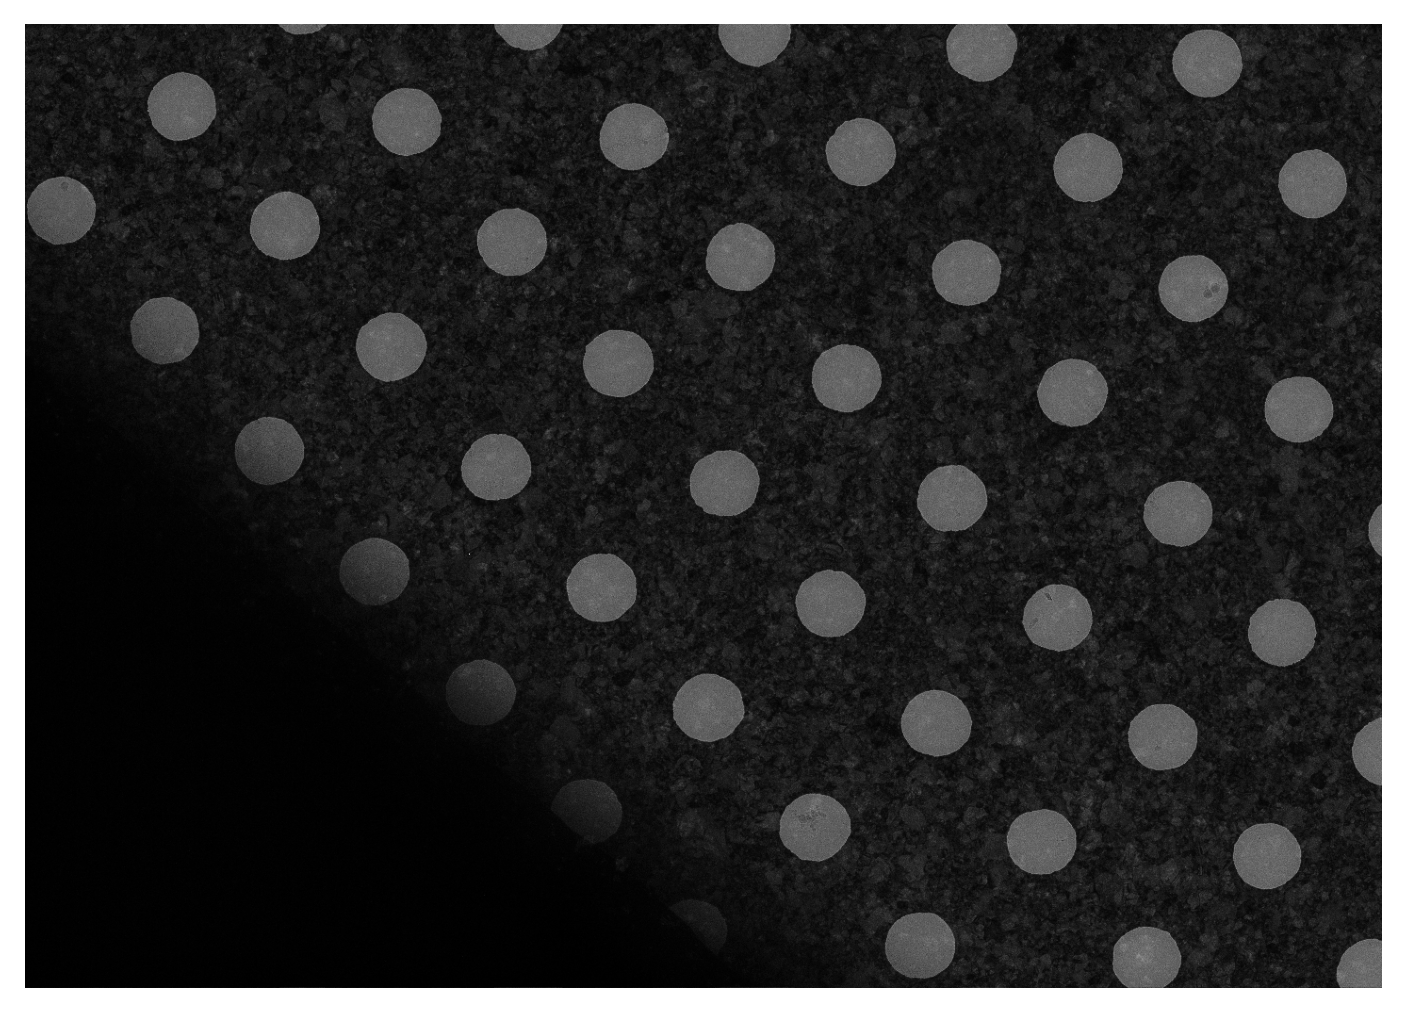

In [816]:
plt.figure(figsize=(7,7), dpi=250)
acquired_mm = load_mrc(session_path + 'hl/22084563.mrc')
plt.imshow(acquired_mm, cmap='Greys_r')
plt.axis('off')
plt.show()

In [817]:
# this time, let's use the GP, ignoring holes that have really bad predicted parameters, and re-running the GP after evey explored hole on the remaining holes

In [818]:
payload = {
    'image': acquired_mm.tolist(),
    'grid_id': 0,
    'square_id': 167
}
response = requests.post(baseurl + 'push_and_evaluate_mm', data=json.dumps(payload))
hole_df = pd.read_csv(io.StringIO(response.json()), index_col='hole_id')
hole_df.head()

mm_img_id  square_id  grid_id  radius  prior_score  visited  ctf  \
hole_id                                                                     
51             NaN        167        0      36     0.012018    False  NaN   
52             NaN        167        0      36     0.273471    False  NaN   
53             NaN        167        0      36     0.016969    False  NaN   
54             NaN        167        0      36     0.402946    False  NaN   
55             NaN        167        0      36     0.024276    False  NaN   

         ice_thickness  center_x  center_y  ctf_pred    ice_pred   ctf_var  \
hole_id                                                                      
51                 NaN        34       201  4.762368   77.569070  3.025057   
52                 NaN       162        89  4.009816  111.250046  1.375750   
53                 NaN        19       441  4.770305   76.728806  3.025536   
54                 NaN       147       329  4.611074   82.264220  2.968437   
55                 NaN       275       217  4.183041  111.279880  1.173324   

            ice_var  
hole_id              
51       135.264720  
52        63.584290  
53       135.285160  
54       132.847240  
55        54.642082

In [838]:
updated_hole_df = hole_df
for hole_id, _ in hole_df.iterrows():
    if updated_hole_df.loc[hole_id]['ctf_pred'] < 4.7:
        # pretend we visited the hole and got back ctf and ice thickness
        ctf = np.random.uniform(2.7, 5.6)
        ice = np.random.uniform(70, 140)
        send_visit_hole(hole_id, ctf, ice)
        # this will also automatically remove the hole from the set of active holes, meaning we can acquire the updated hole df by simply calling
        updated_hole_df = pd.read_csv(io.StringIO(requests.get(baseurl+'rerun_mm_on_active_holes').json()), index_col='hole_id')

#### This concludes the tutorial. 

In practice, the ```Ptolemy_Requester``` class more conveniently handles making requests to the Ptolemy server and correctly unpacking outputs.